#Centralized training: define the upper bound

In [1]:
# Import all the necessary libraries
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torch.autograd import Variable
import torch.optim as optim
from torchvision import models
from torchvision import transforms as tt
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time

# set manual seed for reproducibility
# [100, 0, 42] => list of seeds
seed = 0

# general reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# gpu training specific
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

## Dataset definition

Observation: since this work is an implementation of the paper: Deep Residual Learning for Image Recognition, we will stick with the hyperparameters and transformation used inside it. 
The only change happens in the architecture, where we consider both GN (Group Normalization) and BN (Batch Normalization) in two different experiments.

In [2]:
# Use the standard data augmentation pipeline: random crop, random horizontal flip, normalization.
# Observation: The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. Should we use RandomCrop??
# Data transforms (normalization + data augmentation)
# Correct values for mean and std for normalization (normalization is done per channel)
stats = ((0.49139968, 0.48215841, 0.44653091),(0.24703223, 0.24348513, 0.26158784))
# Apply transformations to train dataset
train_transform = tt.Compose([tt.ToTensor(),
                              tt.RandomCrop(32, padding=4), #padding_mode='reflect'),
                              tt.RandomHorizontalFlip(),
                              tt.Normalize(*stats)])
# Apply transformations to test set.
test_transform = tt.Compose([tt.ToTensor(),
                             tt.Normalize(*stats)])
# 1. Define train and test datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=train_transform, download=True)
validation_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=test_transform, download=True)
# 2. Make the dataset iterable
batch_size = 256
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size)

# Check the Iterability (only for the sake of learning purposes)
# If something is not iterable and you pass it as object the result should be False
import collections
print(isinstance(train_loader, collections.Iterable))
print(isinstance(validation_loader, collections.Iterable))
# Check the dimensionality is correct
print(len(train_dataset))
print(len(validation_dataset))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
True
True
50000
10000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working


## Try to display images inside a batch
A subset of the images inside a batch, just 10 images in order to understand if the transformations work smoothly.

torch.Size([256, 3, 32, 32])


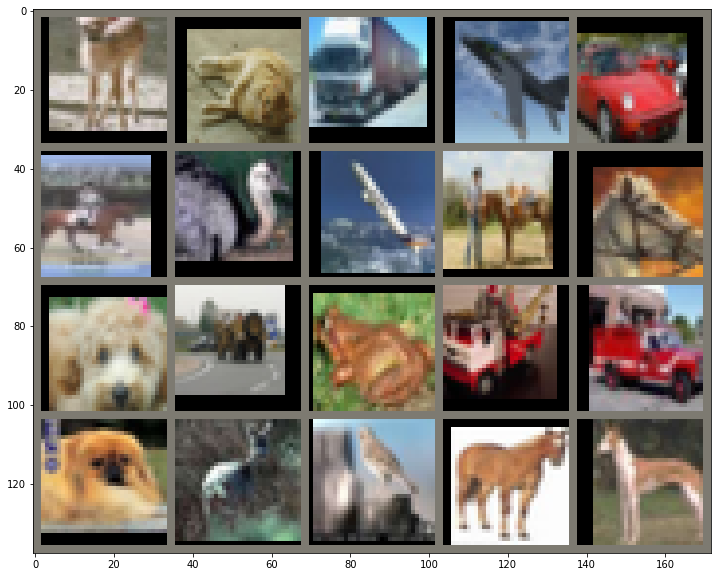

In [3]:
def inv_normalization(im):
    inv_normalize = tt.Normalize(
        mean = [ - 0.4914 / 0.247, - 0.4822 / 0.243, - 0.4465 / 0.261],
        std=[1 / 0.247, 1 / 0.243, 1 / 0.261]
    )
    im_inv = inv_normalize(im)
    return im_inv


def display_batch(train_loader):
    images, labels = next(iter(train_loader))
    print(images.shape)
    im = make_grid(images[:20], nrow=5)
    # Since we have normalized the images in order to display them in
    # the correct way, we have to do a denormalization.
    im_inv = inv_normalization(im)
    plt.figure(figsize=(14, 10))
    plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)))
    plt.show()

display_batch(train_loader)

## Network Architecture + Model Definition


### Group Normalization Layer


In [4]:
class MyGroupNorm(nn.Module):
    def __init__(self, num_channels):
        super(MyGroupNorm, self).__init__()
        self.norm = nn.GroupNorm(num_groups=2, num_channels=num_channels,
                                 eps=1e-5, affine=True)
    
    def forward(self, x):
        x = self.norm(x)
        return x

## Model definition

In [5]:
# 3. Model definition with BatchNormalization layers
BN_model = models.resnet50(pretrained=False, num_classes=10)
print(BN_model)
# numel method returns the total number of elements in the input tensor.
print(f"Parameters per layer: {[p.numel() for p in BN_model.parameters()]} ")
print(f"Total number of parameters: {sum([p.numel() for p in BN_model.parameters()])}")

# Model definition with GroupNormalization layers
GN_model = models.resnet.ResNet(models.resnet.Bottleneck, [3, 4, 6, 3], num_classes=10, zero_init_residual=False, groups=1, width_per_group=64, replace_stride_with_dilation=None, norm_layer=MyGroupNorm)
print(GN_model)
# numel method returns the total number of elements in the input tensor.
print(f"Parameters per layer: {[p.numel() for p in GN_model.parameters()]} ")
print(f"Total number of parameters: {sum([p.numel() for p in GN_model.parameters()])}")

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Loss definition, Optimizer definition

In [6]:
# 4. Loss defintion
criterion = nn.CrossEntropyLoss()
epochs = 150
# 5. Optimizer defintion 
learning_rate = 1e-4
max_learning_rate = 1e-3
momentum = 0.9
weight_decay = 1e-4
# betas=(0.9, 0.999) default values for Adam optmizer
BN_optimizer = optim.Adam(BN_model.parameters(), lr=learning_rate,  weight_decay=weight_decay)
GN_optimizer = optim.Adam(GN_model.parameters(), lr=learning_rate,  weight_decay=weight_decay)

#BN_optimizer = optim.SGD(BN_model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
#GN_optimizer = optim.SGD(GN_model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
# Scheduler for decreasing the learning rate
BN_scheduler = torch.optim.lr_scheduler.OneCycleLR(BN_optimizer, max_lr=max_learning_rate, epochs=epochs, steps_per_epoch=len(train_loader))
GN_scheduler = torch.optim.lr_scheduler.OneCycleLR(GN_optimizer, max_lr=max_learning_rate, epochs=epochs, steps_per_epoch=len(train_loader))

## Training Loop

In [8]:
import seaborn as sns
sns.set()

def get_lr(optimizer):
  """
    return the value of the current learning rate
  """
  for param_group in optimizer.param_groups:
      return param_group['lr']

def train_vs_validation_loss(epochs, train_losses, val_losses):
  # VISUALIZATIONS: TRAIN LOSS VS VALIDATION LOSS
  # LEARNING CURVE
  plt.figure()
  plt.plot(range(epochs), train_losses, label='train loss')
  plt.plot(range(epochs), val_losses, label='val loss')
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title("TRAIN LOSS VS VALIDATION LOSS")
  plt.savefig("/content/learning_curve.png")
  plt.show()

def training_loop(model, optimizer, epochs, scheduler, train_loader, validation_loader, len_validation):
  """
    params:
      model: model which we want to train
      optimizer: SGD or Adam optimizers
      epochs: number of epochs
      scheduler: scheduler used for chaging the learning rate
      train_loader: DataLoader for the train loader
      validation_loader: DataLoader for the validation loader
      len_validation: length of validation dataset, could be calculated by len(validation_loader)*batch_size
  """
  """
  last_epoch = 0
  MODEL_SAVED = '/content/drive/MyDrive/Colab Notebooks/checkpoint/model_.pt'
  checkpoint = torch.load(MODEL_SAVED)
  last_epoch = checkpoint['epoch']
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  train_losses = checkpoint['training_loss_x_epoch']
  val_losses = checkpoint['validation_loss_x_epoch']
  scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
  """
  MODEL_SAVED = 'model_.pt'
  # Gradient Clipping
  grad_clip = True
  # Move the model on the GPU
  # assert torch.cuda.device_count() > 0, "Fail: No GPU device detected"
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  model = model.to(device)
  train_losses = []
  val_losses = []
  lrs = []
  valid_loss_min = np.Inf # track change in validation loss
  # Start the training loop
  for epoch in range(epochs):
    # Set the model in "training mode"
    model.train()
    running_training_loss = 0.0
    running_val_loss = 0.0
    correct = 0
    for i, (images, labels) in enumerate(train_loader):
      current_batch = len(images)
      # Put images on the GPU
      images = Variable(images.to(device))
      labels = Variable(labels.to(device))
      # Reset the gradients
      optimizer.zero_grad()
      # Take the outputs
      outputs = model(images)
      # Calculate the loss
      loss = criterion(outputs, labels)
      # Calculate the gradients
      loss.backward()
      # Apply Gradient Clipping
      if grad_clip: 
          nn.utils.clip_grad_value_(model.parameters(), clip_value=0.1)
      # Updates the parameters
      optimizer.step()
      # OneCycle Scheduler
      scheduler.step() 
      # Store teh value of the current learning rate
      lrs.append(get_lr(optimizer))
      # Weighted AVG = loss * batch_size / len(dataset)
      running_training_loss += loss.item() * current_batch
    # In the end we store one loss per epoch...
    train_losses.append(running_training_loss / len(train_dataset))
    # Set the network in evaluation mode
    model.eval()
    # VALIDATION PHASE
    with torch.no_grad():
      for j, (val_images, val_labels) in enumerate(validation_loader):
        current_batch = len(val_labels)
        # Send the batch to the GPU
        val_images = Variable(val_images.to(device))
        val_labels = Variable(val_labels.to(device))
        # Get the outputs
        val_output = model(val_images)
        # Loss evaluation
        val_loss = criterion(val_output, val_labels)
        running_val_loss += val_loss.item() * current_batch
        # Get the prediction for the accuracy
        _, prediction = torch.max(val_output, 1)
        # The result of the masking is a boolean, but we can sum the values, since True = 1, and False = 0
        correct += (prediction.cpu() == val_labels.cpu()).sum()

    # Also one validation loss per epoch is stored
    # curr_val_los = running_val_loss / len(validation_dataset)
    curr_val_los = running_val_loss / len_validation
    #scheduler.step(curr_val_los)
    val_losses.append(curr_val_los)
    #accuracy = 100 * (correct / len(validation_dataset)) # Note: validation_dataset, not validation_loader
    accuracy = 100 * (correct / len_validation) # Note: validation_dataset, not validation_loader

    print(
          f"Epoch:({epoch + 1}/{epochs})" 
          f" - Training Loss: {running_training_loss / len(train_dataset):.5e} "
          f" - Validation Loss: { (running_val_loss / len_validation): .5e}"
          f" - Training Accuracy: {accuracy:.3e}"
          f" - lr: {optimizer.state_dict()['param_groups'][0]['lr']:.2e}")
    
    # save model if validation loss has decreased
    if curr_val_los <= valid_loss_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
      valid_loss_min,
      curr_val_los))
      # CHECKPOINT  
      torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'training_loss_x_epoch': train_losses,
        'validation_loss_x_epoch': val_losses,
      }, MODEL_SAVED)
      valid_loss_min = curr_val_los
     
  print(f"total time {(time.time() - start_time) / 60 :.2f} minutes")
  train_vs_validation_loss(epochs, train_losses, val_losses)
  return model

# Start 
start_time = time.time()
BN_model = training_loop(model=BN_model, optimizer=BN_optimizer, epochs=epochs, scheduler=BN_scheduler, train_loader=train_loader,validation_loader = validation_loader , len_validation = len(validation_dataset))
GN_model = training_loop(model=GN_model, optimizer=GN_optimizer, epochs=epochs, scheduler=GN_scheduler, train_loader=train_loader,validation_loader = validation_loader , len_validation = len(validation_dataset)) 

Epoch:(1/150) - Training Loss: 1.12221e+00  - Validation Loss:  1.09499e+00 - Training Accuracy: 6.178e+01 - lr: 4.43e-04
Validation loss decreased (inf --> 1.094988).  Saving model ...


KeyboardInterrupt: ignored